<a href="https://colab.research.google.com/github/paruliansaragi/DL-Notebooks/blob/master/Colab_filtering_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [0]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip


Redirecting output to ‘wget-log’.


In [0]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [0]:
path='ml-latest-small/'

In [0]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Create subset for Excel
We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [0]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [0]:
#Collaborative filtering
val_idxs=get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [0]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [0]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   
    0      0.743492   0.774001  
    1      0.746974   0.754237  
    2      0.578411   0.736822  



[array([0.73682])]

In [0]:
preds = learn.predict()

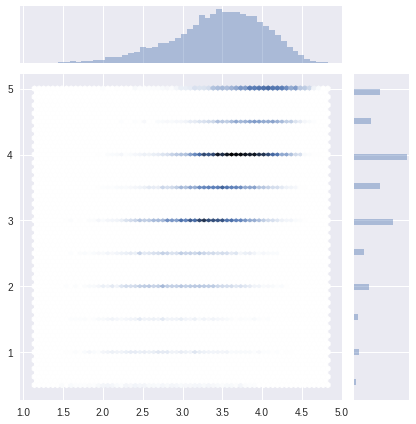

In [0]:
y = learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None)

## Analyze results
### Movie bias

In [0]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [0]:
m=learn.model; 

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [0]:
movie_bias = to_np(m.ib(V(topMovieIdx)))


In [0]:
movie_bias

array([[ 0.94325],
       [ 1.30519],
       [ 0.80101],
       ...,
       [-0.26849],
       [ 0.11102],
       [ 0.0589 ]], dtype=float32)

In [0]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies, movie_bias)]

In [0]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.7073023, 'Catwoman (2004)'),
 (-0.68670917, 'Speed 2: Cruise Control (1997)'),
 (-0.6857086, 'Battlefield Earth (2000)'),
 (-0.6540013, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.64605975, 'Anaconda (1997)'),
 (-0.6451647, 'Karate Kid, Part III, The (1989)'),
 (-0.63411283, 'Super Mario Bros. (1993)'),
 (-0.6134684, 'Problem Child (1990)'),
 (-0.6033605, 'Honey, I Blew Up the Kid (1992)'),
 (-0.60153985, 'Scary Movie 2 (2001)'),
 (-0.60077125, 'Wild Wild West (1999)'),
 (-0.5955466, 'Batman & Robin (1997)'),
 (-0.59542066, 'Superman IV: The Quest for Peace (1987)'),
 (-0.5827886, 'Teenage Mutant Ninja Turtles III (1993)'),
 (-0.5612441, 'Godzilla (1998)')]

In [0]:
sorted(movie_ratings, key=itemgetter(0))[:15]


[(-0.7073023, 'Catwoman (2004)'),
 (-0.68670917, 'Speed 2: Cruise Control (1997)'),
 (-0.6857086, 'Battlefield Earth (2000)'),
 (-0.6540013, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.64605975, 'Anaconda (1997)'),
 (-0.6451647, 'Karate Kid, Part III, The (1989)'),
 (-0.63411283, 'Super Mario Bros. (1993)'),
 (-0.6134684, 'Problem Child (1990)'),
 (-0.6033605, 'Honey, I Blew Up the Kid (1992)'),
 (-0.60153985, 'Scary Movie 2 (2001)'),
 (-0.60077125, 'Wild Wild West (1999)'),
 (-0.5955466, 'Batman & Robin (1997)'),
 (-0.59542066, 'Superman IV: The Quest for Peace (1987)'),
 (-0.5827886, 'Teenage Mutant Ninja Turtles III (1993)'),
 (-0.5612441, 'Godzilla (1998)')]

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3051925, 'Shawshank Redemption, The (1994)'),
 (0.9511952,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.9432487, 'Forrest Gump (1994)'),
 (0.8972625, 'Usual Suspects, The (1995)'),
 (0.89210474, 'Casablanca (1942)'),
 (0.8894393, 'Fight Club (1999)'),
 (0.8708536, 'Dark Knight, The (2008)'),
 (0.85783, 'Goodfellas (1990)'),
 (0.85508895, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.8514168, 'Godfather, The (1972)'),
 (0.8498984, 'Departed, The (2006)'),
 (0.8480383, 'Matrix, The (1999)'),
 (0.8420777, "Schindler's List (1993)"),
 (0.8323852, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.83196944, 'Godfather: Part II, The (1974)')]

## Embedding interpretation
We can now do the same thing for the embeddings.

In [0]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [0]:
movie_pca.shape

(3, 3000)

In [0]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(0.096378066, 'Pulp Fiction (1994)'),
 (0.07408663, 'Big Lebowski, The (1998)'),
 (0.06756054, 'Godfather, The (1972)'),
 (0.06636669, 'Fight Club (1999)'),
 (0.06620461, 'Monty Python and the Holy Grail (1975)'),
 (0.06472871, 'Godfather: Part II, The (1974)'),
 (0.06406092, 'Apocalypse Now (1979)'),
 (0.06380399, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.063069105, 'Graduate, The (1967)'),
 (0.062294204, '2001: A Space Odyssey (1968)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]


[(-0.06603586, 'Twister (1996)'),
 (-0.057954583, 'Congo (1995)'),
 (-0.056828767, 'Mummy, The (1999)'),
 (-0.055850998, 'Richie Rich (1994)'),
 (-0.05554361, 'Lara Croft: Tomb Raider (2001)'),
 (-0.052227907, 'Batman Forever (1995)'),
 (-0.051002886, 'Broken Arrow (1996)'),
 (-0.049791794, 'Bone Collector, The (1999)'),
 (-0.04978991, 'First Knight (1995)'),
 (-0.04956919, 'Crocodile Dundee II (1988)')]

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]
#Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(0.055819057, "Boys Don't Cry (1999)"),
 (0.054425683, 'Mulholland Drive (2001)'),
 (0.054106236, 'Battlefield Earth (2000)'),
 (0.054015286, 'Happiness (1998)'),
 (0.050528668, 'Heavenly Creatures (1994)'),
 (0.050225753, 'Lost Highway (1997)'),
 (0.04719883, 'Master of Disguise, The (2002)'),
 (0.044963777, 'Hours, The (2002)'),
 (0.041369718, 'Predator 2 (1990)'),
 (0.04078309, 'Fried Green Tomatoes (1991)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]


[(-0.09320034, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.091274545, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.08809473, 'Speed (1994)'),
 (-0.087249555, 'Forrest Gump (1994)'),
 (-0.08520552, 'Back to the Future (1985)'),
 (-0.08415068, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.081021, 'E.T. the Extra-Terrestrial (1982)'),
 (-0.08087157, 'Braveheart (1995)'),
 (-0.08038252, 'Shrek 2 (2004)'),
 (-0.07646815, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

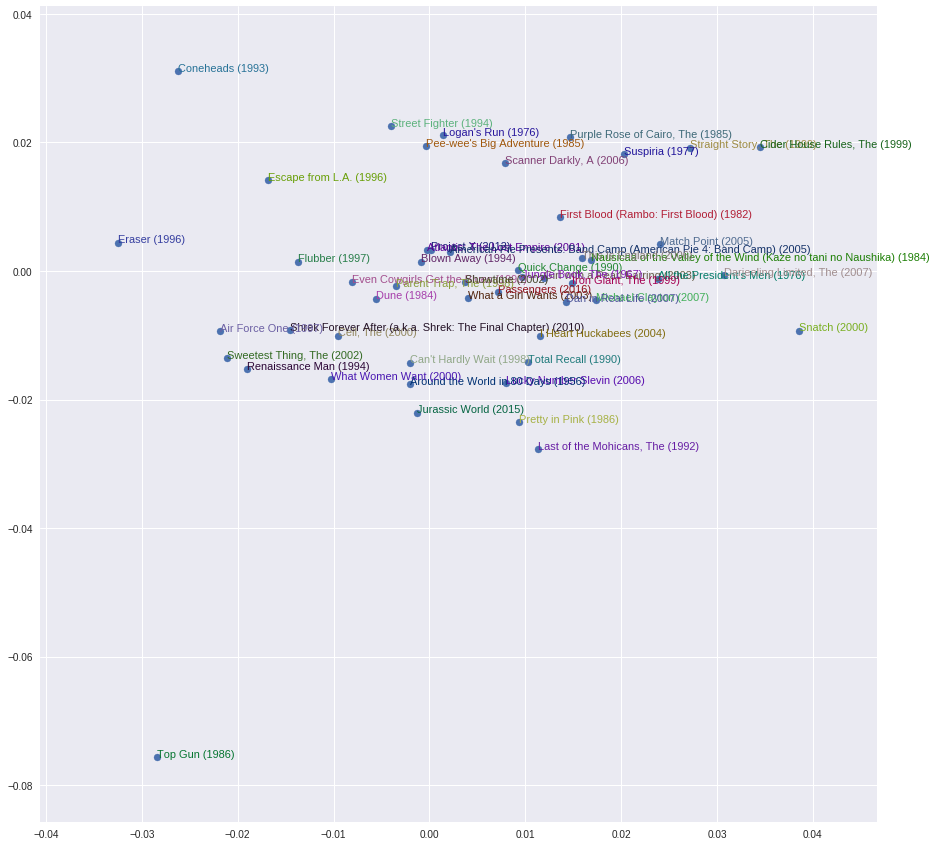

In [0]:
'''
We can draw a picture to see how various movies appear on the map of these components. 
This picture shows the first two components.
'''

idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for i, x, y in zip(topMovies[idxs], X, Y):
  plt.text(x,y, movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch
### Dot product example

In [0]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [0]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [0]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [0]:
class DotProduct(nn.Module):
  def forward(self, u, m): return (u*m).sum(1)

In [0]:
model=DotProduct()

In [0]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model


In [0]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [0]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [0]:
x = ratings.drop(['rating', 'timestamp'], axis=1)
y = ratings['rating'].astype(np.float32)


In [0]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [0]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies)
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)


In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      1.677782   1.60197   
    1      1.094143   1.303268  
    2      0.898543   1.22474   



[array([1.22474])]

## Bias

In [0]:

min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

In [0]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items)
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [0]:
fit(model, data, 3, opt, F.mse_loss)


epoch      trn_loss   val_loss   
    0      0.817164   0.813736  
    1      0.76273    0.79521   
    2      0.742406   0.788501  



[array([0.7885])]

In [0]:
set_lrs(opt, 1e-2)


In [0]:
fit(model, data, 3, opt, F.mse_loss)


epoch      trn_loss   val_loss   
    0      0.710692   0.782207  
    1      0.677164   0.780503  
    2      0.699388   0.779634  



[array([0.77963])]

In [0]:

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies)
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)


In [0]:
fit(model, data, 3, opt, F.mse_loss)


epoch      trn_loss   val_loss   
    0      0.862429   0.79579   
    1      0.811202   0.776878  
    2      0.777248   0.77384   



[array([0.77384])]

In [0]:
set_lrs(opt, 1e-3)


In [0]:
fit(model, data, 3, opt, F.mse_loss)


epoch      trn_loss   val_loss   
    0      0.793911   0.774675  
    1      0.763842   0.773682  
    2      0.747167   0.772509  



[array([0.77251])]